# Subreddit Classification with Natural Language Processing

## Modeling with $k$-Nearest Neighbors

*Author: Grace Campbell*

#### Project Directory
1. Data Preparation 
    - [Data Gathering](http://localhost:8889/notebooks/projects/project_3/data-gathering.ipynb)
    - [Exploratory Data Analysis](http://localhost:8889/notebooks/projects/project_3/exploratory-data-analysis.ipynb)
2. Modeling
    - [Naive Bayes](http://localhost:8889/notebooks/projects/project_3/modeling-naive-bayes.ipynb)
    - *$k$-Nearest Neighbors*
    - [Support-Vector Machine](http://localhost:8889/notebooks/projects/project_3/modeling-svm.ipynb)

### Model Introduction

In this notebook, I will be modeling with `KNeighborsClassifier`, which uses the $k$-Nearest Neighbors algorithm (a non-parametric method) to predict the class of a data point. The algorithm looks at the class membership of the $k$ closest neighbors to the query point; whichever class is the most represented among the neighbors is the class that gets predicted for the query point.  

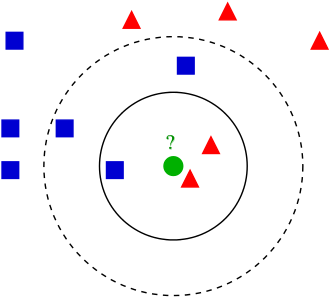 [Image source](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Algorithm)

In the example above, the green dot is the query point. If $k$ is 3, then the majority class for the 3 nearest neighbors is 'red triangle', so the model will predict that class for the query point. If $k$ is 5, however, the majority class becomes 'blue square', so that is what the model will predict.

### Modeling Strategy

Before I can begin modeling, I need to turn my text data into numeric data using `TfidfVectorizer`. This transformer will create a matrix of values, where the columns represent every word that appears in the corpus, and the rows represent each document in the corpus. The values are TFIDF statistics for each word in a document.

TFIDF stands for "term frequency-inverse document frequency" (**term frequency**: the number of times a word occurs in a document; **inverse document frequency**: an inverse function of the number of documents that contain the term). According to [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), "[t]he tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."

Both of these methods have hyperparameters that can be tuned to optimize model performance, so I will perform a grid search using a pipeline with `TfidfVectorizer` and `KNeighborsClassifier` to find the best parameters for both in the context of one another. 

The grid search will test 3 different `TfidfVectorizer` hyperparameters:
1. `max_features`: how many features to extract (chosen by highest total frequency)
2. `min_df`: the minimum number of documents in which a feature must appear
3. `max_df`: the maximum percentage of documents in which a feature can appear

and 2 different `KNeighborsClassifier` hyperparameters:
1. `n_neighbors`: the $k$ in $k$-Nearest Neighbors -- how many neighbors to compare a data point to in order to decide its class
2. `weights`: the weight given to the neighbors (whether all are weighted equally or more weight is given to neighbors closer to the point in question)

### Grid Searching for Best Hyperparameters

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

from tokenizer import token_func

df = pd.read_csv('./materials/titles.csv')

In [2]:
# Creating X and y
X = df['title']
y = df['is_onion']

# Train-test splitting (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [3]:
# Instantiating a pipeline
pipe = Pipeline([
    ('tvec', TfidfVectorizer(tokenizer=token_func)),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters to search over
params = {
    'tvec__max_features': [None, 1000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [0.9, 1.0],
    'knn__n_neighbors': [15, 25, 35],
    'knn__weights': ['uniform', 'distance']
}

# Fitting the grid search
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X_train, y_train);

In [4]:
grid.best_score_

0.8037068239258636

In [5]:
# Which parameters did the grid search choose?
grid.best_params_

{'knn__n_neighbors': 15,
 'knn__weights': 'distance',
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 1}

For `TfidfVectorizer`, the grid search decided:   

- `max_features` should be None
    - I will have to investigate how many features are kept in the model when there is no maximum. I do not want many more features than I have rows in `X_train` (to prevent collinearity), so I may have to set the `max_features` anyway, regardless of this grid search result.


- `min_df` should be 1, effectively meaning there is no minimum document frequency
    - Again, I need to see how many features the model keeps, and may need to change `min_df` anyway.


- `max_df` should be 0.9, meaning a feature will not be included in the model if it appears in more than 90% of the documents
    - Since I eliminated stopwords from the tokens, there most likely will not be many (if any) words that show up in more than 90% of the titles.
    
    
For `KNeighborsClassifier`, the grid search decided:

- `n_neighbors` should be 15
    - The 15 neighbors closest to the query point will be considered. I believe that 15 neighbors is a number that results in a good bias-variance trade-off: it is small enough that the bias is relatively low, but not so small that the variance is extremely high.
    

- `weights` should be `distance`
    - The closer a neighbor is to the query point, the more influence that point will have over the class prediction. Neighbors that are farther away will have less influence.

### Transforming `X` Using Best Parameters

As I suspected, there are almost 3 times more features in `X_train` than there are rows when `max_features` is None and `min_df` is only 1. After some adjustments, I found setting `max_features` to 2000 still results in a good score while not having too many more features than there are observations.

In [6]:
tvec = TfidfVectorizer(tokenizer=token_func, max_features=2000, min_df=1, max_df=0.9)

tvec.fit(X_train)

X_train_t = pd.DataFrame(tvec.transform(X_train).todense(), columns=tvec.get_feature_names())
X_test_t  = pd.DataFrame(tvec.transform(X_test).todense(), columns=tvec.get_feature_names())

### Running the Optimized Model

In [7]:
# Instantiating and fitting the model
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train_t, y_train)

# Storing predictions
y_pred = knn.predict(X_test_t)

In [8]:
# Accuracy score
knn.score(X_test_t, y_test)

0.8156565656565656

In [9]:
# Confusion Matrix + other metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f'True Positives: {tp}')
print(f'False Negatives: {fn}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}\n')
print(f'Sensitivity: {tp/(tp+fn)}')
print(f'Specificity: {tn/(tn+fp)}')

True Positives: 224
False Negatives: 13
True Negatives: 99
False Positives: 60

Sensitivity: 0.9451476793248945
Specificity: 0.6226415094339622


### Interpretation of Results

The baseline accuracy score for the data is the score I would get if I predicted the majority class for every data point. The majority class here, /r/TheOnion, holds around 60% of the data. If I were to predict that every document in the data belonged to /r/TheOnion, I would get an accuracy score of 60%. That is to say, if a model does not predict subreddit membership with greater than 60% accuracy, then it is not a very good model.

The fewer features in this model, the poorer its performance. When its `max_features` was None, the model had ~4000 features and scored around 84%, meaning that the model correctly predicted the class 84% of the time. After reducing the `max_features` to 2000, the accuracy score dropped slightly to 82%. When `max_features` was dropped to the number of rows, 1187, the accuracy score dropped further, to around 70%. To get the highest possible accuracy score from this model, I would need to gather more data so that the model could use more features to make predictions.

The model has very high sensitivity, meaning that almost all of the posts that were actually from /r/TheOnion were correctly predicted to be from /r/TheOnion. On the flip side, the model has much lower specificity, which means that only about 62% of posts that belong to /r/News were correctly predicted to be from /r/News. It seems that this model is content to predict the positive class almost every time. 

In a real-world application, it is equally important to me that this model be able to correctly predict when a post is satirical **and** when it is real. The positive class in this case is does not hold more weight than the negative class, therefore I would rather the model be very accurate than very sensitive. For this reason, I do not believe $k$-Nearest Neighbors, at least not this iteration, is the best model for my purposes.